# Determining a "Good" Credit Card Applicant

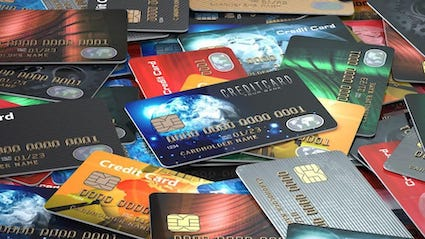

By: Sukanya Joshi, Bushra Kidwai, and Shreyans Tiwari

In this project, we intend to study relationships between the factors that influence the credit card approval rate for applicants, like occupation type and income level. The objective of our project is to build a classifier with the highest accuracy to figure out whether an applicant is likely to get their credit card approved or not. Finally, we are using various machine learning models such as K-nearest neighbors and Random Forest to figure out which classifies our data with the highest accuracy score.

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## About the Dataset 

We have two datasets, application_df and credit_df. Let's first start with our data description to understand these datasets. We will be using the describe, is.na(), dtypes, and shape functions to do this.

**application_df** is a dataset with application information which tracks the personal information such as annual income, gender, and education level of an applicant.

**credit_df** has credit record information which tracks the user behavior of an applicant such as how many days their payment was overdue.

In [82]:
application_df = pd.read_csv("/content/drive/MyDrive/application_record.csv")
credit_df = pd.read_csv("/content/drive/MyDrive/credit_record.csv")

In [83]:
application_df.describe(include='all')

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
count,4.385570e+05,438557,438557,438557,438557.000000,4.385570e+05,438557,438557,438557,438557,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,304354,438557.000000
unique,NaN,2,2,2,NaN,NaN,5,5,5,6,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN
top,NaN,F,N,Y,NaN,NaN,Working,Secondary / secondary special,Married,House / apartment,NaN,NaN,NaN,NaN,NaN,NaN,Laborers,NaN
freq,NaN,294440,275459,304074,NaN,NaN,226104,301821,299828,393831,NaN,NaN,NaN,NaN,NaN,NaN,78240,NaN
mean,6.022176e+06,NaN,NaN,NaN,0.427390,1.875243e+05,NaN,NaN,NaN,NaN,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,NaN,2.194465
std,5.716370e+05,NaN,NaN,NaN,0.724882,1.100869e+05,NaN,NaN,NaN,NaN,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,NaN,0.897207
min,5.008804e+06,NaN,NaN,NaN,0.000000,2.610000e+04,NaN,NaN,NaN,NaN,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,NaN,1.000000
25%,5.609375e+06,NaN,NaN,NaN,0.000000,1.215000e+05,NaN,NaN,NaN,NaN,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,NaN,2.000000
50%,6.047745e+06,NaN,NaN,NaN,0.000000,1.607805e+05,NaN,NaN,NaN,NaN,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,NaN,2.000000
75%,6.456971e+06,NaN,NaN,NaN,1.000000,2.250000e+05,NaN,NaN,NaN,NaN,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,NaN,3.000000


In [84]:
credit_df.describe(include='all')

,ID,MONTHS_BALANCE,STATUS
count,1.048575e+06,1.048575e+06,1048575
unique,NaN,NaN,8
top,NaN,NaN,C
freq,NaN,NaN,442031
mean,5.068286e+06,-1.913700e+01,NaN
std,4.615058e+04,1.402350e+01,NaN
min,5.001711e+06,-6.000000e+01,NaN
25%,5.023644e+06,-2.900000e+01,NaN
50%,5.062104e+06,-1.700000e+01,NaN
75%,5.113856e+06,-7.000000e+00,NaN


Let's figure out the number of null values in each column for both of our dataframes.

In [85]:
credit_df.isna().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [86]:
application_df.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

We can see above that there are no missing values for all of the columns in credit_df. As for application_df, only the OCCUPATION_TYPE column has missing values. We will drop this column later when we conduct our label encoding since a significant portion of the values from this column are missing. 


In [87]:
application_df.shape

(438557, 18)

In [88]:
credit_df.shape

(1048575, 3)

In [89]:
application_df.dtypes

ID                       int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED            int64
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
dtype: object

In [90]:
credit_df.dtypes

ID                 int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object

## Data Pre-Processing
In this section, we will clean our dataset to get meaningful information that can be used in our models later on.

For credit_df, the MONTHS_BALANCE column is month at the starting point where 0 is the current month, -1 is the previous month, and so on. Below is the key of the STATUS column which describes in how many days an applicant has paid off their credit card.

**C**: paid off that month

**0**: 1-29 days past due

**1**: 30-59 days past due

**2**: 60-89 days overdue

**3**: 90-119 days overdue

**4**: 120-149 days overdue

**5**: Overdue or bad debts, write-offs for more than 150 days

**X**: No loan for the month

First, we drop all rows from the credit_df dataset where the STATUS column is 'X" because an applicant having no loan for the month is not a strong indicator of whether or not they will be a good credit card applicant.

In [91]:
idx = credit_df[credit_df["STATUS"] == "X"].index
clean_credit_df = credit_df.drop(idx)
clean_credit_df

,ID,MONTHS_BALANCE,STATUS
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


### Formulating the Labels

We grouped clean_credit_df by ID and STATUS in order to get the total count of how many times a candidate paid their bill in X amount of time.

In [92]:
count_credit = clean_credit_df.groupby(["ID","STATUS"])["MONTHS_BALANCE"].count().reset_index(name="COUNT")
count_credit

,ID,STATUS,COUNT
0,5001711,0,3
1,5001712,0,10
2,5001712,C,9
3,5001717,0,17
4,5001717,C,5
...,...,...,...
69133,5150482,C,6
69134,5150484,0,12
69135,5150484,C,1
69136,5150485,0,2


Then, we added a column called TOTAL_MONTHS to get the total number of months that an applicant has data for. Finally, we created a NORMALIZED_COUNT column to get the probability of how many times an applicant paid their bill in X amount of time. For example, the applicant with the ID number 5001712 paid their bill within 1-29 days past the due date for about 53% of the time, and paid their bill on time 47% of the time.

In [93]:
num_months = count_credit.groupby("ID")["COUNT"].sum().reset_index(name="TOTAL_MONTHS")
count_credit = count_credit.merge(num_months, on="ID")
count_credit["NORMALIZED_COUNT"] = round(count_credit["COUNT"]/count_credit["TOTAL_MONTHS"], 2)
count_credit

,ID,STATUS,COUNT,TOTAL_MONTHS,NORMALIZED_COUNT
0,5001711,0,3,3,1.00
1,5001712,0,10,19,0.53
2,5001712,C,9,19,0.47
3,5001717,0,17,22,0.77
4,5001717,C,5,22,0.23
...,...,...,...,...,...
69133,5150482,C,6,18,0.33
69134,5150484,0,12,13,0.92
69135,5150484,C,1,13,0.08
69136,5150485,0,2,2,1.00


We defined a "good" credit card applicant as someone who paid their bill on time more than 85% of the time. We chose this threshold because we tested numerous values and found that our accuracy was at its peak with this value. Once we crossed this threshold, our accuracy dropped. Here are all of the values we tested along with their accuracies.

Threshold vs Best Accuracy:

0.70 –> 0.76685

0.75 –> 0.79133

0.80 –> 0.81874

0.85 –> 0.86167

0.90 –> 0.82034

Furthermore, we defined a "bad" credit card applicant as someone who has not achieved the 85% threshold or who pays their bill after 90 days. We then created a new column called APPROVE which we set to 1 for good applicants and 0 for bad applicants. This serves as our label for our machine learning models that we will implement later. We created two new dataframes: **good_applicants_df** and **bad_applicants_df**, both of which consist of two columns: one with the applicant's ID and the other with the corresponding APPROVE label (0 or 1).

In [94]:
good_applicants_df = count_credit[count_credit["STATUS"] == "C"][count_credit["NORMALIZED_COUNT"] > 0.85]
bad_applicants_id = pd.unique(count_credit[(count_credit["STATUS"] == "3") | (count_credit["STATUS"] == "4") | (count_credit["STATUS"] == "5")]["ID"])
good_applicants_df = good_applicants_df[~good_applicants_df["ID"].isin(bad_applicants_id)]
good_applicants_df["APPROVE"] = 1
good_applicants_df.drop(["STATUS", "COUNT", "TOTAL_MONTHS", "NORMALIZED_COUNT"], axis=1, inplace=True)
good_applicants_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,ID,APPROVE
9,5001719,1
13,5001724,1
21,5001730,1
24,5001735,1
36,5001743,1
...,...,...
69106,5150422,1
69125,5150475,1
69128,5150478,1
69129,5150479,1


In [95]:
bad_applicants_df = count_credit[~count_credit["ID"].isin(good_applicants_df["ID"])].drop_duplicates(subset=["ID"])
bad_applicants_df["APPROVE"] = 0
bad_applicants_df.drop(["STATUS", "COUNT", "TOTAL_MONTHS", "NORMALIZED_COUNT"], axis=1, inplace=True)
bad_applicants_df

,ID,APPROVE
0,5001711,0
1,5001712,0
3,5001717,0
5,5001718,0
10,5001720,0
...,...,...
69127,5150477,0
69130,5150480,0
69132,5150482,0
69134,5150484,0


We created a large **combined_df** by combining the good_applicants_df and bad_applicants_df. Then, we created an **applicant_df** by joining the previous application_df with this combined_df on the ID number. This applicant_df consists of all of the features along with the respective "APPROVE" column per ID.

In [96]:
combined_df = pd.concat([good_applicants_df, bad_applicants_df])

In [97]:
applicant_df = application_df.merge(combined_df, on="ID")
applicant_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,APPROVE
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33105,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,Managers,2.0,0
33106,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,0
33107,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,0
33108,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,Sales staff,2.0,0


We dropped the "FLAG_MOBIL" column as all of the entries were 1, which did not add any value to our analysis. We then plotted a correlation matrix to understand the relationships between the features and assess multicollinearity.

In [98]:
correlation_matrix = applicant_df.drop(labels=["FLAG_MOBIL"], axis=1).corr()
correlation_matrix

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,APPROVE
ID,1.000000,0.026094,-0.012722,0.053936,-0.038049,0.080844,0.013876,-0.047297,0.022572,0.010352
CNT_CHILDREN,0.026094,1.000000,0.037617,0.341226,-0.231211,0.048964,-0.016430,0.020126,0.888412,-0.003292
AMT_INCOME_TOTAL,-0.012722,0.037617,1.000000,0.070722,-0.166270,-0.033096,0.018423,0.092916,0.025476,-0.013664
DAYS_BIRTH,0.053936,0.341226,0.070722,1.000000,-0.615963,0.178382,-0.025386,0.106993,0.303485,-0.012756
DAYS_EMPLOYED,-0.038049,-0.231211,-0.166270,-0.615963,1.000000,-0.243647,-0.009989,-0.086149,-0.219322,0.003543
FLAG_WORK_PHONE,0.080844,0.048964,-0.033096,0.178382,-0.243647,1.000000,0.314704,-0.032959,0.063232,0.010260
FLAG_PHONE,0.013876,-0.016430,0.018423,-0.025386,-0.009989,0.314704,1.000000,0.013613,-0.004784,-0.008464
FLAG_EMAIL,-0.047297,0.020126,0.092916,0.106993,-0.086149,-0.032959,0.013613,1.000000,0.018313,-0.003471
CNT_FAM_MEMBERS,0.022572,0.888412,0.025476,0.303485,-0.219322,0.063232,-0.004784,0.018313,1.000000,-0.000005
APPROVE,0.010352,-0.003292,-0.013664,-0.012756,0.003543,0.010260,-0.008464,-0.003471,-0.000005,1.000000


The heatmap below shows a high positive correlation between CNT_FAM_MEMBERS and CNT_CHILDREN and a negative correlation between DAYS_EMPLOYED and CNT_CHILDREN, and DAYS_EMPLOYED and DAYS_BIRTH (The days birth column has negative values since it is counting back from the current date).

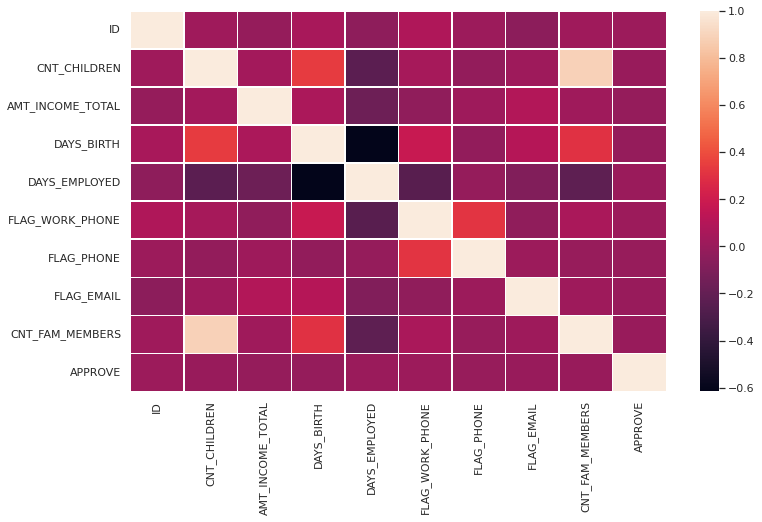

In [99]:
sns.set(rc = {'figure.figsize': (12, 7)})
sns.heatmap(correlation_matrix, linewidths=0.5)


The pie chart below shows the percentage of different income types like - working, student, state servant, pensioner, commercial associate in our dataset.

([<matplotlib.patches.Wedge at 0x7f398da58cd0>,
 [Text(-0.05693519875356445, 1.1485897366522533, 'Working'),
  Text(-0.7822520831763259, -0.8429600692596886, 'Commercial associate'),
  Text(0.5639718767313155, -1.0022154071137392, 'Pensioner'),
  Text(1.1108475953740362, -0.2975191083808267, 'State servant'),
  Text(1.1499993734340948, -0.0012004587413436472, 'Student')],
 [Text(-0.032180764512884256, 0.6492028946295343, '52%'),
  Text(-0.44214248179531457, -0.47645569132069343, '23%'),
  Text(0.3187667129350914, -0.5664695779338526, '17%'),
  Text(0.6278703799940204, -0.16816297430220636, '8%'),
  Text(0.6499996458540536, -0.000678520158150757, '0%')])

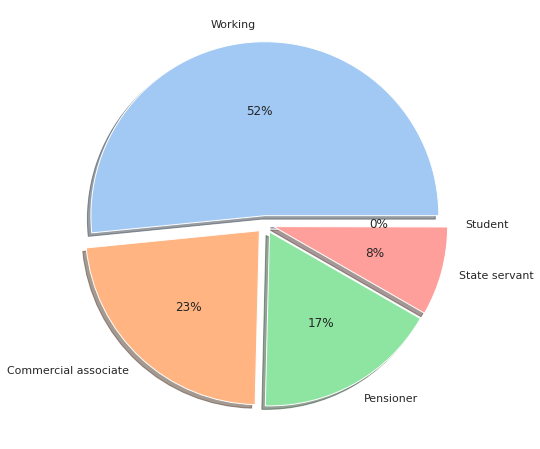

In [100]:
income_data = applicant_df['NAME_INCOME_TYPE'].value_counts()
colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(8, 8))
plt.pie(income_data, labels=income_data.index, colors = colors, shadow=True, explode=[0.05] * len(income_data), autopct='%.0f%%')

The pie chart below shows the percentage of male and female applicants in our dataset.

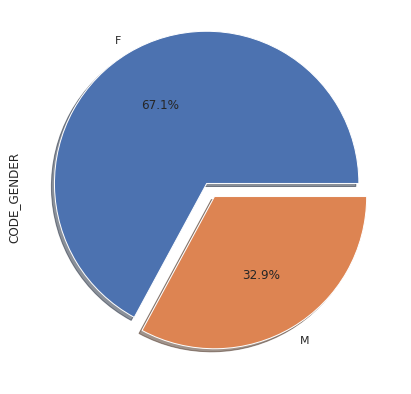

In [101]:
applicant_df['CODE_GENDER'].value_counts().plot(kind='pie', explode=(0.1,0), shadow=True, autopct='%1.1f%%')

Here we show the distribution for different categories of occupation type in our dataset.

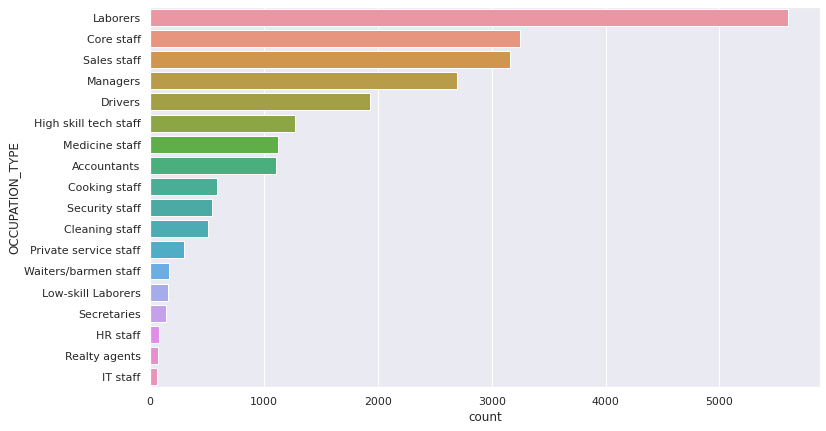

In [102]:
ax = sns.countplot(y ='OCCUPATION_TYPE',data = applicant_df,order=applicant_df['OCCUPATION_TYPE'].value_counts().index)

#applicant_df['OCCUPATION_TYPE'].value_counts().sort_values().plot(kind='barh', figsize=(9,12))

Here, we show the distribution of the years employed for each applicant in our dataset.

Here, we use the DAYS_EMPLOYED column to generate YEARS_EMPLOYED data.

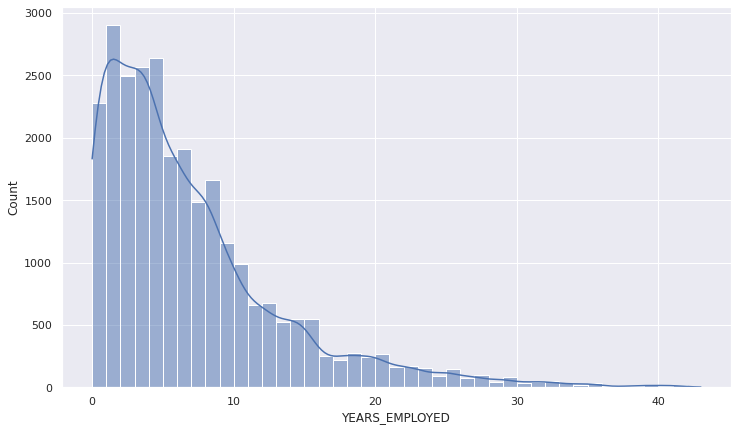

In [103]:
applicant_df['YEARS_EMPLOYED'] = -(applicant_df['DAYS_EMPLOYED'])//365	
applicant_df['YEARS_EMPLOYED'] = applicant_df['YEARS_EMPLOYED'].apply(lambda x: np.nan if x < 0 else x)
applicant_df['YEARS_EMPLOYED'].fillna(applicant_df['YEARS_EMPLOYED'].mean(),inplace=False)
sns.histplot(data=applicant_df, x="YEARS_EMPLOYED",binwidth = 1,kde=True)

We can see that the plot is skewed towards the right. This implies that most of the applicants in our dataset have been employed for <10 years, with the peak being around the 2-year mark.

We are showing the comparison of counts of different categorical features with respect to our labels 'Approved' and 'Not Approved'. 
We take the following features in account for the 9 plots:


*   NAME_INCOME_TYPE
*   CODE_GENDER
*   NAME_EDUCATION_TYPE
*   NAME_FAMILY_STATUS
*   NAME_HOUSING_TYPE
*   FLAG_OWN_REALTY
*   FLAG_OWN_CAR
*   FLAG_PHONE
*   OCCUPATION_TYPE

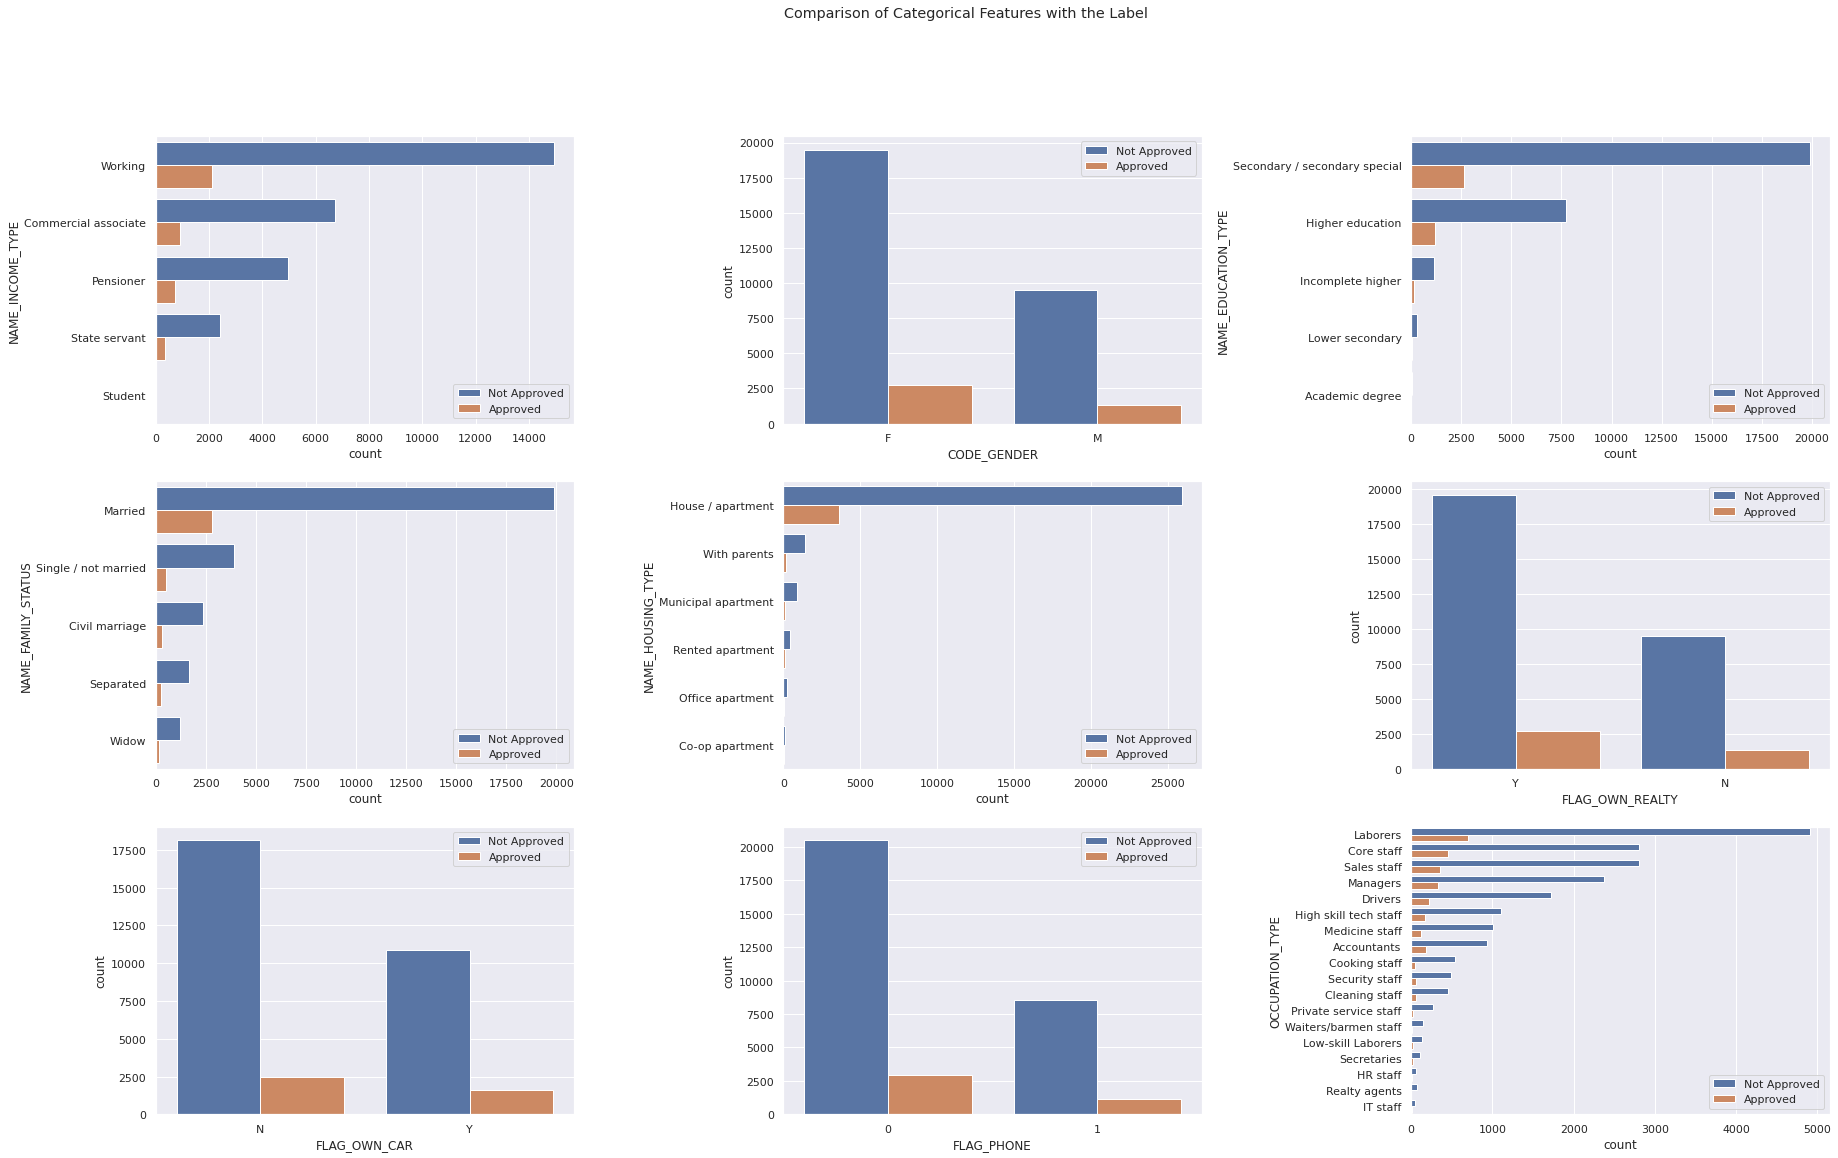

In [104]:
#income type, gender, education type, family status, housing type
#based on our analysis above, we are now going to check the correlation between approved and non-approved credit card applicants based on various categorical features
fig, axes = plt.subplots(3, 3, figsize=(30, 18))
fig.suptitle('Comparison of Categorical Features with the Label')

sns.countplot(y='NAME_INCOME_TYPE', data=applicant_df, order=applicant_df['NAME_INCOME_TYPE'].value_counts().index, hue='APPROVE', ax=axes[0, 0])
sns.countplot(x='CODE_GENDER', data=applicant_df, order=applicant_df['CODE_GENDER'].value_counts().index, hue='APPROVE', ax=axes[0, 1])
sns.countplot(y='NAME_EDUCATION_TYPE', data=applicant_df, order=applicant_df['NAME_EDUCATION_TYPE'].value_counts().index, hue='APPROVE', ax=axes[0, 2])
sns.countplot(y='NAME_FAMILY_STATUS', data=applicant_df, order=applicant_df['NAME_FAMILY_STATUS'].value_counts().index, hue='APPROVE', ax=axes[1, 0])
sns.countplot(y='NAME_HOUSING_TYPE', data=applicant_df, order=applicant_df['NAME_HOUSING_TYPE'].value_counts().index, hue='APPROVE', ax=axes[1, 1])
sns.countplot(x='FLAG_OWN_REALTY', data=applicant_df, order=applicant_df['FLAG_OWN_REALTY'].value_counts().index, hue='APPROVE', ax=axes[1, 2])
sns.countplot(x='FLAG_OWN_CAR', data=applicant_df, order=applicant_df['FLAG_OWN_CAR'].value_counts().index, hue='APPROVE', ax=axes[2, 0])
sns.countplot(x='FLAG_PHONE', data=applicant_df, order=applicant_df['FLAG_PHONE'].value_counts().index, hue='APPROVE', ax=axes[2, 1])
sns.countplot(y='OCCUPATION_TYPE', data=applicant_df, order=applicant_df['OCCUPATION_TYPE'].value_counts().index, hue='APPROVE', ax=axes[2, 2])

plt.subplots_adjust(wspace = 0.5)

for i in range(3):
  for j in range(3):
    if(i + j == 0 or ((i + j == 2) and (j != 0)) or i + j == 4):
      axes[i, j].legend(['Not Approved', 'Approved'], loc='lower right')
    else:
      axes[i, j].legend(['Not Approved', 'Approved'])

In [105]:
applicant_df['FLAG_MOBIL'].value_counts()

1    33110
Name: FLAG_MOBIL, dtype: int64

The box plot gives the five-number summary, the minimum, first quartile, median, third quartile, and maximum for the feature- AMT_INCOME_TOTAL

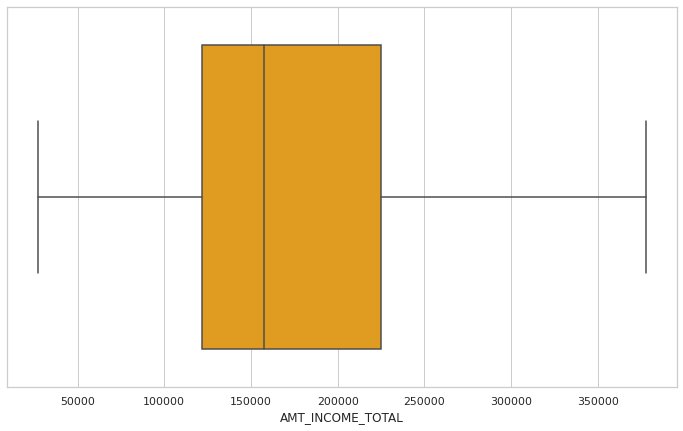

In [106]:
#Boxplot of income
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=applicant_df["AMT_INCOME_TOTAL"], showfliers = False, color='orange')

We can observe that the boxplot is skewed to the right, i.e. positively skewed, with the median being around 155000.

Now, we create a copy of our dataframe and drop the columns which are not required as features for our machine learning models.

In [107]:
applicant_df_features = applicant_df.copy()
applicant_df_features.drop(labels=['OCCUPATION_TYPE', 'DAYS_EMPLOYED', 'ID', 'FLAG_MOBIL'], axis=1, inplace=True)

Let's make the categorical features usable for our models by applying label encoding.

In [108]:
from sklearn.preprocessing import LabelEncoder

# Encoding
le = LabelEncoder()

applicant_df_features['NAME_INCOME_TYPE'] = le.fit_transform(applicant_df_features['NAME_INCOME_TYPE'])
applicant_df_features['NAME_EDUCATION_TYPE'] = le.fit_transform(applicant_df_features['NAME_EDUCATION_TYPE'])
applicant_df_features['NAME_FAMILY_STATUS'] = le.fit_transform(applicant_df_features['NAME_FAMILY_STATUS'])
applicant_df_features['NAME_HOUSING_TYPE'] = le.fit_transform(applicant_df_features['NAME_HOUSING_TYPE'])
applicant_df_features['CODE_GENDER'] = le.fit_transform(applicant_df_features['CODE_GENDER'])
applicant_df_features['FLAG_OWN_CAR'] = le.fit_transform(applicant_df_features['FLAG_OWN_CAR'])
applicant_df_features['FLAG_OWN_REALTY'] = le.fit_transform(applicant_df_features['FLAG_OWN_REALTY'])

We observe that the DAYS_BIRTH feature has negative values, counting back from the current date. So, we need convert this data to positive values.

In [109]:
applicant_df_features['DAYS_BIRTH'] = applicant_df_features['DAYS_BIRTH'].apply(lambda x: -x if x <= 0 else np.nan)

applicant_df_features['DAYS_BIRTH'].fillna(0, inplace=True)
applicant_df_features['YEARS_EMPLOYED'].fillna(0, inplace=True)

A final look at our cleaned and processed dataframe:

In [110]:
applicant_df_features

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,APPROVE,YEARS_EMPLOYED
0,1,1,1,0,427500.0,4,1,0,4,12005,1,0,0,2.0,1,12.0
1,1,1,1,0,427500.0,4,1,0,4,12005,1,0,0,2.0,1,12.0
2,1,1,1,0,112500.0,4,4,1,1,21474,0,0,0,2.0,0,3.0
3,0,0,1,0,270000.0,0,4,3,1,19110,0,1,1,1.0,0,8.0
4,0,0,1,0,270000.0,0,4,3,1,19110,0,1,1,1.0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33105,1,1,1,0,315000.0,4,4,1,1,17348,0,0,0,2.0,0,6.0
33106,0,0,1,0,157500.0,0,1,1,1,12387,0,1,1,2.0,0,3.0
33107,0,0,1,0,157500.0,1,1,1,1,12387,0,1,1,2.0,0,3.0
33108,0,0,1,0,283500.0,4,4,1,1,17958,0,0,0,2.0,0,1.0


In [111]:
correlation_matrix2 = applicant_df_features.corr()
correlation_matrix2

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,APPROVE,YEARS_EMPLOYED
CODE_GENDER,1.000000,0.362383,-0.049421,0.082230,0.198405,0.106577,0.006437,-0.101223,0.071594,-0.203301,0.063298,-0.026774,0.001254,0.114607,0.002289,-0.037661
FLAG_OWN_CAR,0.362383,1.000000,-0.015010,0.107404,0.216668,0.056061,-0.102139,-0.123104,0.017382,-0.157626,0.021918,-0.007794,0.018205,0.154458,0.010214,0.000752
FLAG_OWN_REALTY,-0.049421,-0.015010,1.000000,-0.005714,0.032018,-0.045744,0.011641,0.020712,-0.179106,0.129706,-0.202582,-0.064186,0.053501,-0.008160,-0.000402,-0.035169
CNT_CHILDREN,0.082230,0.107404,-0.005714,1.000000,0.037617,0.108611,-0.051149,-0.159663,0.024764,-0.341226,0.048964,-0.016430,0.020126,0.888412,-0.003292,0.039431
AMT_INCOME_TOTAL,0.198405,0.216668,0.032018,0.037617,1.000000,-0.072831,-0.228061,0.003405,-0.003470,-0.070722,-0.033096,0.018423,0.092916,0.025476,-0.013664,0.085138
NAME_INCOME_TYPE,0.106577,0.056061,-0.045744,0.108611,-0.072831,1.000000,0.053607,-0.044738,0.037685,-0.214644,0.165384,0.005903,-0.020504,0.105853,0.006400,0.187659
NAME_EDUCATION_TYPE,0.006437,-0.102139,0.011641,-0.051149,-0.228061,0.053607,1.000000,0.009454,-0.036158,0.171074,-0.020082,-0.046339,-0.100540,-0.043055,-0.021372,-0.015427
NAME_FAMILY_STATUS,-0.101223,-0.123104,0.020712,-0.159663,0.003405,-0.044738,0.009454,1.000000,0.014420,0.103453,-0.060595,-0.016641,-0.011710,-0.547095,-0.008797,-0.042006
NAME_HOUSING_TYPE,0.071594,0.017382,-0.179106,0.024764,-0.003470,0.037685,-0.036158,0.014420,1.000000,-0.213361,0.027188,-0.022353,0.014747,0.004057,-0.002630,-0.028125
DAYS_BIRTH,-0.203301,-0.157626,0.129706,-0.341226,-0.070722,-0.214644,0.171074,0.103453,-0.213361,1.000000,-0.178382,0.025386,-0.106993,-0.303485,0.012756,-0.006000


After applying label encoding, an additional high negative correlations between CNT_FAM_MEMBERS and NAME_FAMILY_STATUS is found in our dataset.

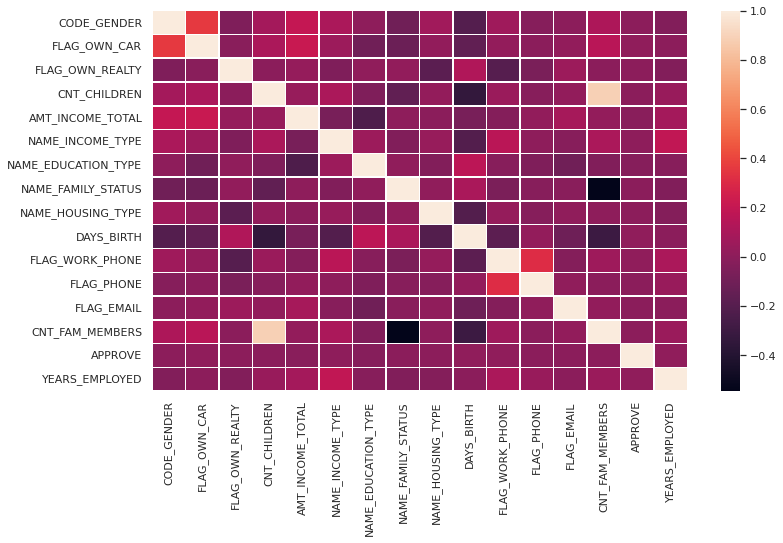

In [112]:
sns.set(rc = {'figure.figsize': (12, 7)})
sns.heatmap(correlation_matrix2, linewidths=0.5)

## Machine Learning Algorithms
Now that we have cleaned up our dataset and analysed relationships between attributes using various plots, let's move on to building efficient classification models that will determine whether a credit card application is approved or not.
<br>
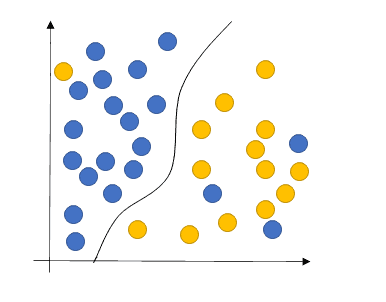
<br>
An underlying goal of this task is to compare various models and figure out which one is the best fit for our requirement. To carry out this comparison, we will be testing the following five classification algorithms:


*   Logistic Regression
*   k-Nearest Neighbors
*   Decision Tree
*   Random Forest
*   Support Vector Machines

We will look at the accuracy scores and the confusion matrices to analyse the results.
<br><br>
To start off, let's separate out the features and labels from the dataset.




In [113]:
features = applicant_df_features.drop(labels=['APPROVE'], axis=1)
labels = applicant_df_features['APPROVE']

In [114]:
labels.value_counts()

0    29041
1     4069
Name: APPROVE, dtype: int64

### Handling Imbalance in the Dataset
In the previous code block, we used ```labels.value_count()``` to see the distribution of the labels in our dataset. This distribution tells us that about 77.36% of the entries are classified as 0 (bad applicant) and only 22.64% are classified as 1 (good applicant), thus showing the imbalance in our dataset.
To handle this imbalance, we will use an oversampling technique known as <b>SMOTE</b>. 
<br><br>
SMOTE (Synthetic Minority Oversampling Technique) selects entries that are close in the feature space, draws a line between the entries and creates new samples at various points along this line.
<br>

As part of our analysis, we will test our models for two cases:


*   Applying SMOTE on the whole dataset (i.e. before train-test split
*   Applying SMOTE on just the training data (i.e. after train-test split)



1. Applying SMOTE on the Whole Dataset:

In [115]:
from imblearn.over_sampling import SMOTE

features_smote, labels_smote = SMOTE().fit_resample(features, labels)

### Train-Test Split
We perform an 80-20 split on our dataset to get the train and test sets.

In [116]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [117]:
x_train_smote, x_test_smote, y_train_smote, y_test_smote = train_test_split(features_smote, labels_smote, test_size=0.2, random_state=42)

2. Applying SMOTE on the training data:

In [118]:
x_train_bal, y_train_bal = SMOTE().fit_resample(x_train, y_train)

### Principal Component Analysis

Now, we'll apply PCA to find the most useful features in our dataset and handle multicollinearity. First, let's do this for our upsampled training data ```x_train_bal, y_train_bal```.

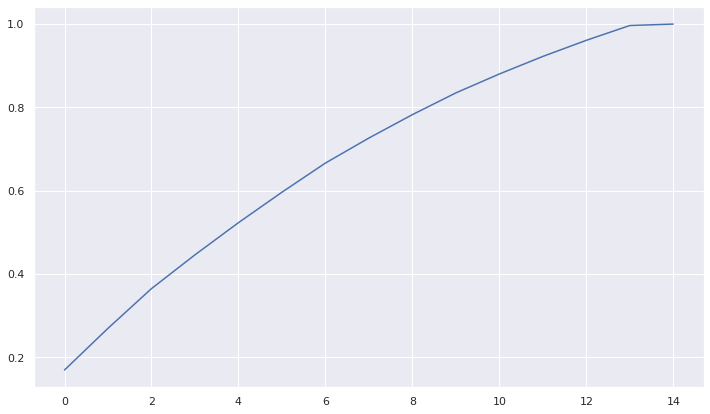

In [119]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
x_train_bal = scaler.fit_transform(x_train_bal)
x_test = scaler.transform(x_test)

pca = PCA(n_components=15)
x_train_2 = pca.fit_transform(x_train_bal)

plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [120]:
np.cumsum(pca.explained_variance_ratio_)

array([0.16952519, 0.26961596, 0.36489254, 0.44600589, 0.52316835,
       0.59630617, 0.6663016 , 0.72639401, 0.7825504 , 0.83474561,
       0.88016017, 0.92230607, 0.96097348, 0.99653632, 1.        ])

From the plot, we can see that 13 principal components can explain for >95% of the variance in the label classes.

In [121]:
# We use 13 principal components
pca = PCA(n_components=13)

x_train_bal = pca.fit_transform(x_train_bal)
x_test = pca.transform(x_test)

Now we apply PCA to the training data ```x_train_smote, y_train_smote``` from our upsampled dataset.

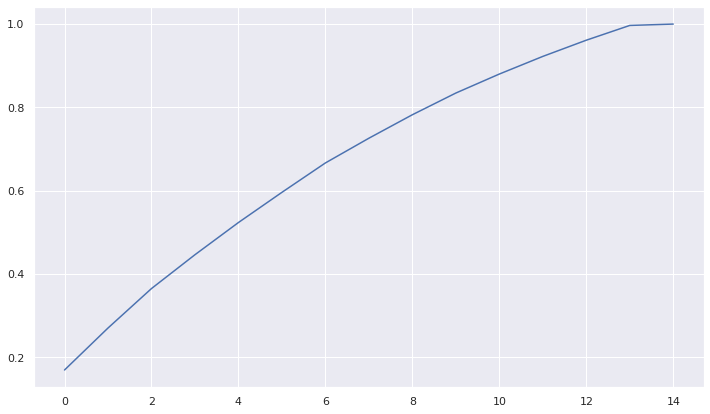

In [122]:
x_train_smote = scaler.fit_transform(x_train_smote)
x_test_smote = scaler.transform(x_test_smote)

pca = PCA(n_components=15)
x_train_2 = pca.fit_transform(x_train_smote)

plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [123]:
# We use 13 principal components
pca = PCA(n_components=13)

x_train_smote = pca.fit_transform(x_train_smote)
x_test_smote = pca.transform(x_test_smote)

### 1. Logistic Regression
We start off our predictive analysis by testing the Logistic Regression algorithm for both cases.


In [124]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0)
lr.fit(x_train_bal, y_train_bal)
test_accuracy = lr.score(x_test, y_test)
print('Logistic Regression Accuracy for SMOTE on Training Data:', test_accuracy)

lr.fit(x_train_smote, y_train_smote)
test_accuracy = lr.score(x_test_smote, y_test_smote)
print('Logistic Regression Accuracy for SMOTE on Whole Dataset:', test_accuracy)

Logistic Regression Accuracy for SMOTE on Training Data: 0.586529749320447
Logistic Regression Accuracy for SMOTE on Whole Dataset: 0.6363088577085306


In [125]:
from sklearn.metrics import confusion_matrix

y_pred = lr.predict(x_test)
print('Confusion Matrix for SMOTE on Training Data:\n', confusion_matrix(y_test, y_pred))

y_pred = lr.predict(x_test_smote)
print('Confusion Matrix for SMOTE on Whole Dataset:\n', confusion_matrix(y_test_smote, y_pred))

Confusion Matrix for SMOTE on Training Data:
 [[3512 2315]
 [ 469  326]]
Confusion Matrix for SMOTE on Whole Dataset:
 [[3531 2268]
 [1957 3861]]


### 2. k-Nearest Neighbors
Next, we move on to the KNN model on the upsampled training data.
<br>We need to find the optimal value of k, i.e. the number of nearest neighbors to check. To get this optimal value, we will make use of GridSearch on k for a range of 1 to 15.

In [126]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()
knn_cv = GridSearchCV(estimator=knc, param_grid={'n_neighbors': list(range(1, 16))}, verbose=1)
knn_cv.fit(x_train_bal, y_train_bal)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15]},
             verbose=1)

In [127]:
print(knn_cv.best_params_)

{'n_neighbors': 1}


We get the optimal k = 1. Now we'll use this value in our KNeighborsClassifier to perform the classification.

In [128]:
knc = KNeighborsClassifier(n_neighbors=1)
knc.fit(x_train_bal, y_train_bal)
accuracy = knc.score(x_test, y_test)

print('KNN Accuracy for SMOTE on Training Data:', accuracy)

KNN Accuracy for SMOTE on Training Data: 0.8104802174569616


In [129]:
y_pred = knc.predict(x_test)
print(confusion_matrix(y_test, y_pred))

[[5043  784]
 [ 471  324]]


Now we perform the same steps on the training data from upsampled dataset.

In [130]:
knc = KNeighborsClassifier()
knn_cv = GridSearchCV(estimator=knc, param_grid={'n_neighbors': list(range(1, 16))}, verbose=1)
knn_cv.fit(x_train_smote, y_train_smote)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15]},
             verbose=1)

In [131]:
print(knn_cv.best_params_)

{'n_neighbors': 1}


In [132]:
knc = KNeighborsClassifier(n_neighbors=1)
knc.fit(x_train_smote, y_train_smote)
accuracy = knc.score(x_test_smote, y_test_smote)

print('KNN Accuracy for SMOTE on Whole Dataset:', accuracy)

KNN Accuracy for SMOTE on Whole Dataset: 0.843763450116209


In [133]:
y_pred = knc.predict(x_test_smote)
print(confusion_matrix(y_test_smote, y_pred))

[[4965  834]
 [ 981 4837]]


### 3. Decision Tree

In [134]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(x_train_bal, y_train_bal)
accuracy = tree.score(x_test, y_test)
print('Decision Tree Accuracy for SMOTE on Training Data:', accuracy)

tree.fit(x_train_smote, y_train_smote)
accuracy = tree.score(x_test_smote, y_test_smote)
print('Decision Tree Accuracy for SMOTE on Whole Dataset:', accuracy)

Decision Tree Accuracy for SMOTE on Training Data: 0.8216550890969495
Decision Tree Accuracy for SMOTE on Whole Dataset: 0.8615821640698975


In [135]:
y_pred = tree.predict(x_test)
print('Confusion Matrix for SMOTE on Training Data:\n', confusion_matrix(y_test, y_pred))

y_pred = tree.predict(x_test_smote)
print('Confusion Matrix for SMOTE on Whole Dataset:\n', confusion_matrix(y_test_smote, y_pred))

Confusion Matrix for SMOTE on Training Data:
 [[3980 1847]
 [ 454  341]]
Confusion Matrix for SMOTE on Whole Dataset:
 [[5092  707]
 [ 901 4917]]


### 4. Random Forest
Number of estimators and maximum depth are important hyperparameters for the random forest algorithm. We will make use of GridSearch again to find the best values for these for our data. First, let's do this for the upsampled training data.

In [136]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params={'n_estimators': [150, 250], 'max_depth': [10, 15]}
rf=RandomForestClassifier(random_state=42)
rf_cv=GridSearchCV(estimator=rf, param_grid=params, verbose=1)
rf_cv.fit(x_train_bal, y_train_bal)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 15], 'n_estimators': [150, 250]},
             verbose=1)

In [137]:
print(rf_cv.best_params_)

{'max_depth': 15, 'n_estimators': 250}


We get the optimal n_estimators = 250 and optimal max_depth = 15. Now we'll use these values in our RandomForestClassifier to perform the classification.

In [138]:
rm=RandomForestClassifier(n_estimators=250, max_depth=15, random_state=42)

rm.fit(x_train_bal, y_train_bal)
test_accuracy = rm.score(x_test, y_test)
print('Random Forest Accuracy:', test_accuracy)

Random Forest Accuracy: 0.7956810631229236


In [139]:
y_pred = rm.predict(x_test)
print(confusion_matrix(y_test, y_pred))

[[4935  892]
 [ 461  334]]


Now we perform the same steps on the training data from the upsampled dataset.

In [140]:
rf=RandomForestClassifier(random_state=42)
rf_cv=GridSearchCV(estimator=rf, param_grid=params, verbose=1)
rf_cv.fit(x_train_smote, y_train_smote)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 15], 'n_estimators': [150, 250]},
             verbose=1)

In [141]:
print(rf_cv.best_params_)

{'max_depth': 15, 'n_estimators': 250}


In [142]:
rm=RandomForestClassifier(n_estimators=250, max_depth=15, random_state=42)

rm.fit(x_train_smote, y_train_smote)
test_accuracy = rm.score(x_test_smote, y_test_smote)
print('Random Forest Accuracy:', test_accuracy)

Random Forest Accuracy: 0.8534905741585608


In [143]:
y_pred = rm.predict(x_test_smote)
print(confusion_matrix(y_test_smote, y_pred))

[[4847  952]
 [ 750 5068]]


### Support Vector Machines

Finally, we have a look at Support Vector Machines.



In [144]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(kernel='linear')
clf.fit(x_train_bal, y_train_bal)
accuracy = clf.score(x_test, y_test)
print('SVM Accuracy for SMOTE on Whole Dataset:', accuracy)

clf.fit(x_train_smote, y_train_smote)
accuracy = clf.score(x_test_smote, y_test_smote)
print('SVM Accuracy for SMOTE on Training Data:', accuracy)

SVM Accuracy for SMOTE on Whole Dataset: 0.5904560555723346
SVM Accuracy for SMOTE on Training Data: 0.6364810191960059


In [145]:
y_pred = clf.predict(x_test)
print('Confusion Matrix for SMOTE on Whole Dataset:\n', confusion_matrix(y_test, y_pred))

y_pred = clf.predict(x_test_smote)
print('Confusion Matrix for SMOTE on Training Data:\n', confusion_matrix(y_test_smote, y_pred))

Confusion Matrix for SMOTE on Whole Dataset:
 [[3520 2307]
 [ 465  330]]
Confusion Matrix for SMOTE on Training Data:
 [[3533 2266]
 [1957 3861]]


## Analysing Our Results

### Accuracy Score Comparison for our Models

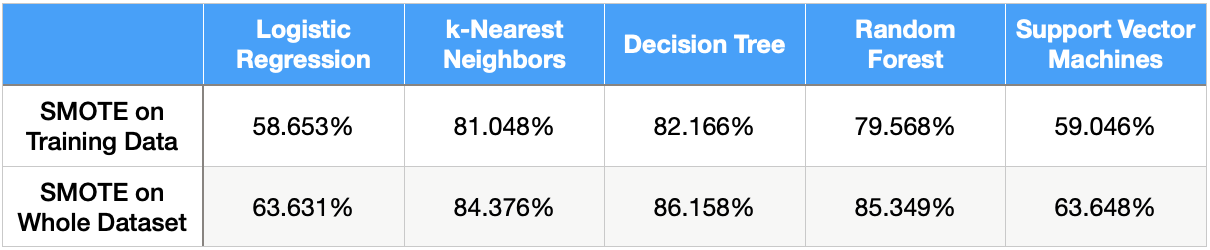
<br><br>
Looking at the final accuracy scores for all models, we can make the following conclusions:

* The Decision Tree Classifier performs the best on our dataset, with an accuracy score of 82.166% when only the training data is upsampled, and 86.158% when the whole dataset is upsampled.

* Applying synthetic oversampling (SMOTE) on the whole dataset inflates the accuracy score. A reason for this may be a bias introduced due to a large number of synthetic samples, making the training and test sets very similar. This may be detrimental to the performance of our models on unseen data.

* Observing the confusion matrices, we can see that the Decision Tree classifier gives the most true positives, followed by Random Forest and KNN. Thus, if we actually want to get the most number of correct predictions for approved applicants, the Decision Tree classifier still seems to be the best fit for our data.

This concludes our data analysis on credit card approval.


Now here's a joke :)
<br><br>

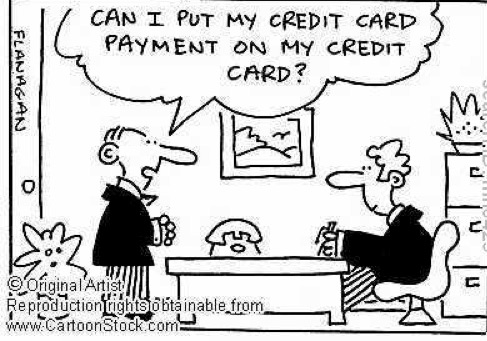